# Session 2 - Multi-Armed Bandits - Assignment

In this assignment you will apply different multi-armed bandit algorithms in order to discover the bandit with highest reward.
We'll start with deterministic bandits, meaning that the bandit rewards are not subject to any underlying stochastic process.
Next we'll focuss on stochastic bandits where the reward of a bandit is the result of a stochastic process and therefore making the discovery of the best bandit much harder. 
Finally we will applay the MAB strategies to solve practical real-life problems.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Deterministic bandits
Assume you have to play 5 bandits with fixed rewards. These rewards are hidden and unknown when you start playing. 
You can play the bandits 100 times. Find out how you can maximize your total reward over these 100 trials.

Use the BanditEnv_1 environment for this experiment.

In [2]:
##### Deterministic Bandit Environment

class BanditEnv_1:
    def __init__(self):
        self.rewards = [-10,6,8,0,-2]
        
    def reset(self):
        self.rewards = [-10,6,8,0,-2]
        
    def step(self,action):
        self.action = action
        return self.rewards[self.action]

In [3]:
# Create an Env1 object
Env1 = BanditEnv_1()
Env1.reset()

In [4]:
# Taken an action. For example choose bandit 0
reward = Env1.step(0)
print('reward =', reward)

reward = -10


If you know in advance that the bandits have fixed rewards, the best strategy will be to play them all once and then pick the one with the highest reward (greedy action).

In [5]:
rewards = []
totalReward = 0
for action in range(5):
    rewards.append(Env1.step(action))
    totalReward = totalReward + reward
    
print(rewards)
bestAction = np.argmax(rewards)
print('Bandit with the highest reward is bandit',bestAction, 'with a reward of',rewards[bestAction])

for i in range(100 - 5):
    rewards.append(Env1.step(bestAction))
    totalReward = totalReward + Env1.step(bestAction)

print('The total reward = ', totalReward)

# Plot the rewards as a funtion of the number of trials
plt.plot(rewards)

[-10, 6, 8, 0, -2]
Bandit with the highest reward is bandit 2 with a reward of 8
The total reward =  710


gy.

Exploration Phase: It pulls every arm exactly once (5 trials) to establish initial estimates.
Selection: It identifies the arm with the highest single reward from the exploration phase.
Exploitation Phase: It exclusively pulls that "best" arm for the remaining 95 trials.
Critique: This approach is highly risky in stochastic environments. If the optimal arm yields a low reward by chance during its single initial trial (noise), the agent will discard it forever and converge on a suboptimal arm (premature convergence). It completely lacks the adaptability to correct initial bad guesses.

Good
Bad


Best bandit = 2 with reward = 8
Total reward over 100 trials = 762


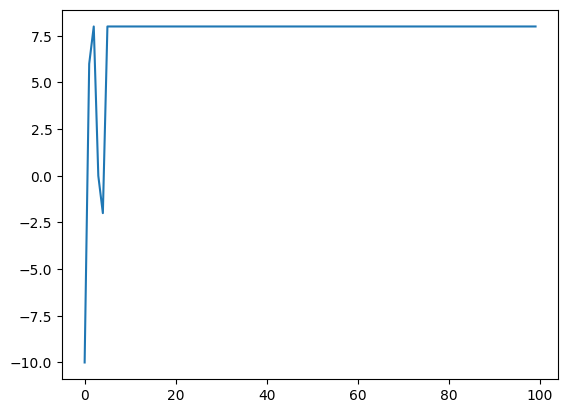

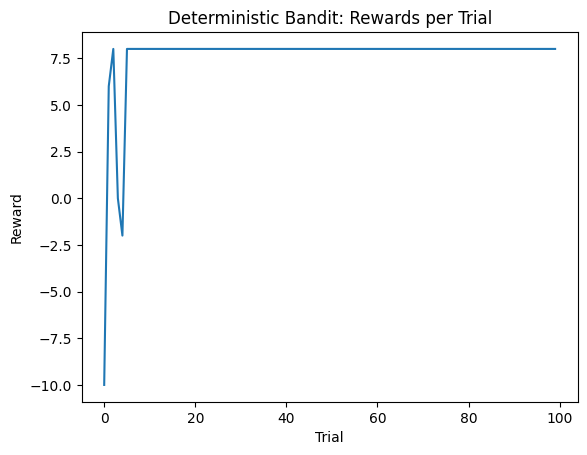

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnv_1:
    def __init__(self):
        self.rewards = [-10, 6, 8, 0, -2]
    def reset(self):
        self.rewards = [-10, 6, 8, 0, -2]
    def step(self, action):
        return self.rewards[action]

# 1) Init
Env1 = BanditEnv_1()
Env1.reset()

rewards_per_trial = []
total_reward = 0

# 2) Explore: pull each bandit once
observed = []
for a in range(5):
    r = Env1.step(a)
    observed.append(r)
    rewards_per_trial.append(r)
    total_reward += r

# 3) Choose best bandit (deterministic => argmax of observed means)
best_action = int(np.argmax(observed))
best_reward = observed[best_action]
print(f"Best bandit = {best_action} with reward = {best_reward}")

# 4) Exploit: pull the best bandit for the remaining trials
for _ in range(100 - 5):
    r = Env1.step(best_action)
    rewards_per_trial.append(r)
    total_reward += r

print("Total reward over 100 trials =", total_reward)  # should be 762

# 5) Plot rewards over trials
plt.figure()
plt.plot(rewards_per_trial)
plt.xlabel("Trial")
plt.ylabel("Reward")
plt.title("Deterministic Bandit: Rewards per Trial")
plt.show()


##### 2. Stochastic bandits

In the case of stochastic bandits, the reward is sampled from an initially unknown distribution. Our task is to discover the expected reward of each of the bandits as quickly (and reliably) as possible. 
As an example, assume that the reward of a bandit comes from a normal distribution with mean = 10 and standard deviation of 5. This means that in 68% procent of the trials this bandit will return a reward between 10-5 = 5 and 10+5 = 15. If you play this bandit multiple times, you can expect that the average reward will converge to 10.

Use BanditEnv_2 for this exercise. All 5 bandits have rewards coming from normal distributions with different means, but with the same standard deviation (std = 1).
You can play this bandit 200 times. Try to come up with a good strategy to maximize the total reward over these 200 trials.

Summary: Stochastic Bandits (The Slot Machine Problem)
Imagine you are in a casino facing 5 different slot machines (bandits).

The Hidden Truth: Each machine has a different average payout. For example, Machine A might pay $10 on average, while Machine B pays $5.
The Problem (Stochastic/Noisy): The machines don't pay the exact average every time.
You pull Machine A (Average $10) → It pays $5 (Bad luck).
You pull Machine B (Average $5) → It pays $8 (Good luck).
The Challenge: If you only tried each once, you would falsely believe Machine B is better! You would spend the rest of your coins on the wrong machine and lose money.
The Goal: You need a strategy to pull the arms enough times to "average out" the luck (noise) and confidently identify the true winner, so you can exploit it for maximum profit.

In [7]:
class BanditEnv_2:
    def __init__(self):
        self.means = [-10,6,8,0,-2]
        self.std = 1
        
    def reset(self):
        self.means = [-10,6,8,0,-2]
        self.std = 1

    def step(self,action):
        self.action = action
        return np.random.normal(self.means[self.action], self.std, 1)[0]

In [8]:
# Create an Env2 object
Env2 = BanditEnv_2()
Env2.reset()
print(Env2.means)

[-10, 6, 8, 0, -2]


Optimal (oracle) expected total: 1600
ε-greedy total: 1388.0
UCB1 total    : 1571.3
Thompson total: 1568.5


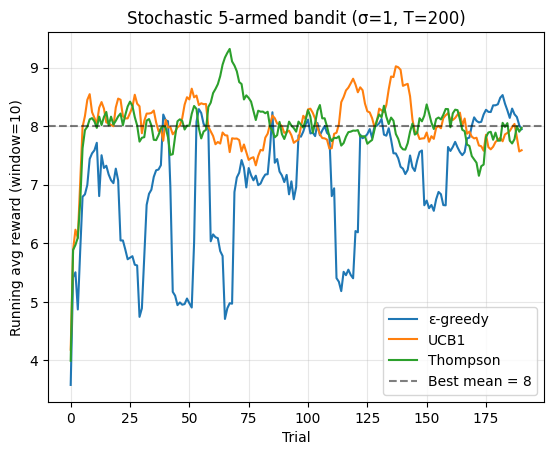

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ========================================
# STOCHASTIC BANDIT ENVIRONMENT
# ========================================
# A "stochastic" bandit means each arm returns RANDOM rewards drawn from a probability distribution.
# Unlike deterministic bandits (where arm 2 always gives 8), here arm 2 gives ~8 on average but varies.

class BanditEnv_2:
    def __init__(self):
        # True mean rewards for each arm (unknown to the agent)
        # Arm 2 with mean=8 is the BEST arm
        self.means = [-10, 6, 8, 0, -2]
        # Standard deviation (noise/randomness) - same for all arms
        self.std = 1
        
    def reset(self):
        # Reset to initial state
        self.means = [-10, 6, 8, 0, -2]
        self.std = 1
    
    def step(self, action):
        # Return a RANDOM reward: true_mean ± random_noise
        # Example: arm 2 might return 7.3, 8.9, 7.1, etc. (around 8)
        return np.random.normal(self.means[action], self.std, 1)[0]

# ========================================
# HELPER FUNCTIONS
# ========================================

def incremental_mean(prev_mean, count, new_value):
    """
    Efficiently update the mean without storing all past values.
    
    Instead of: mean = (r₁ + r₂ + ... + rₙ) / n
    We use: new_mean = old_mean + (new_reward - old_mean) / n
    
    This is the SAME mathematically but saves memory!
    
    Example:
    - After 3 pulls: mean = 7.0, count = 3
    - Get new reward: 9.0
    - Update: 7.0 + (9.0 - 7.0)/4 = 7.0 + 0.5 = 7.5 ✓
    """
    return prev_mean + (new_value - prev_mean) / count

# ========================================
# MAIN BANDIT ALGORITHM
# ========================================

def run_bandit(strategy="ucb", T=200, n_arms=5, seed=0, eps0=0.2, eps_final=0.01):
    """
    Run a multi-armed bandit experiment with different strategies.
    
    Args:
        strategy: Which algorithm to use
            - "eps": Epsilon-greedy (random exploration with probability ε)
            - "ucb": Upper Confidence Bound (optimistic exploration)
            - "ts": Thompson Sampling (Bayesian probability matching)
        T: Total number of arm pulls (trials)
        n_arms: Number of bandit arms (5 in our case)
        seed: Random seed for reproducibility
        eps0: Starting epsilon for ε-greedy
        eps_final: Ending epsilon for ε-greedy
    """
    # Set random seed for reproducible results
    rng = np.random.default_rng(seed)
    
    # Create and initialize environment
    env = BanditEnv_2()
    env.reset()

    # ========================================
    # TRACKING VARIABLES
    # ========================================
    counts = np.zeros(n_arms, dtype=int)    # How many times we pulled each arm
    means  = np.zeros(n_arms, dtype=float)  # Estimated mean reward for each arm
    rewards = []                             # History of all rewards received

    # ========================================
    # THOMPSON SAMPLING SETUP (Bayesian)
    # ========================================
    # Thompson Sampling maintains a BELIEF (posterior distribution) about each arm's true mean.
    # We model: "What do I think the true mean of arm i is?"
    # Answer: "I think it's Normal(post_mu[i], post_var[i])"
    
    mu0 = np.zeros(n_arms)           # Prior belief: "I think all arms have mean ≈ 0"
    var0 = np.ones(n_arms) * 10      # Prior uncertainty: "But I'm very unsure (variance=10)"
    
    post_mu  = mu0.copy()   # Posterior mean: updated belief after seeing data
    post_var = var0.copy()  # Posterior variance: updated uncertainty after seeing data
    
    # As we collect data, post_var DECREASES (we become more certain) and post_mu converges to truth

    # ========================================
    # PHASE 1: WARM-START (Initialize)
    # ========================================
    # Pull each arm ONCE to avoid division-by-zero errors and seed our estimates
    for a in range(n_arms):
        r = env.step(a)           # Pull arm 'a' and observe reward
        counts[a] = 1             # We've now pulled this arm once
        means[a] = r              # Our first estimate = first observation
        rewards.append(r)         # Record reward
        
        # Thompson Sampling: Update our belief after seeing one observation
        # Math: If prior is N(μ₀, σ₀²) and we observe r with noise σ²=1
        # Then posterior is N(μ_new, σ_new²) where:
        #   1/σ_new² = 1/σ₀² + 1/1  (precisions ADD)
        #   μ_new = σ_new² * (μ₀/σ₀² + r/1)  (weighted average)
        post_var[a] = 1.0 / (1.0/var0[a] + 1.0)
        post_mu[a]  = post_var[a] * (mu0[a]/var0[a] + r)

    # ========================================
    # PHASE 2: MAIN LOOP (Learn & Optimize)
    # ========================================
    for t in range(n_arms, T):  # t goes from 5 to 199 (195 more pulls)
        
        # -------------------------------------
        # STRATEGY 1: EPSILON-GREEDY
        # -------------------------------------
        if strategy == "eps":
            # Linearly decay epsilon: start at 0.2 (20% random), end at 0.01 (1% random)
            # Early on: EXPLORE more (high ε)
            # Later on: EXPLOIT more (low ε)
            frac = t / (T - 1)  # Progress from 0.0 to 1.0
            eps = eps0 + (eps_final - eps0) * frac  # Linear interpolation
            
            if rng.random() < eps:
                # EXPLORE: Pick a random arm
                a = rng.integers(0, n_arms)
            else:
                # EXPLOIT: Pick the arm with highest estimated mean
                a = int(np.argmax(means))

        # -------------------------------------
        # STRATEGY 2: UCB1 (Upper Confidence Bound)
        # -------------------------------------
        elif strategy == "ucb":
            # UCB1 Formula: μ̂ᵢ + √(2·ln(t) / nᵢ)
            #   μ̂ᵢ = estimated mean of arm i
            #   nᵢ = number of times arm i was pulled
            #   The bonus √(2·ln(t) / nᵢ) is LARGER for arms we've tried less
            # 
            # Intuition: "Pick the arm that COULD be the best (optimistic)"
            # - If we're unsure about an arm (small nᵢ), give it a large bonus
            # - If we've tried it many times (large nᵢ), bonus shrinks
            bonuses = np.sqrt(2.0 * np.log(t + 1) / counts)
            a = int(np.argmax(means + bonuses))  # Pick arm with highest UCB

        # -------------------------------------
        # STRATEGY 3: THOMPSON SAMPLING
        # -------------------------------------
        elif strategy == "ts":
            # Thompson Sampling: "Probability Matching"
            # 1. For each arm, sample a θᵢ from our belief distribution N(post_mu[i], post_var[i])
            # 2. Pick the arm with the highest sampled θᵢ
            # 
            # Intuition: "Sample what I THINK each arm might be, then pick the best"
            # - If I'm very sure arm 2 is best → post_var[2] is small → θ₂ always high
            # - If I'm unsure about arm 3 → post_var[3] is large → θ₃ varies a lot
            theta_samples = rng.normal(post_mu, np.sqrt(post_var))
            a = int(np.argmax(theta_samples))

        else:
            raise ValueError("Unknown strategy. Use 'eps', 'ucb', or 'ts'.")

        # -------------------------------------
        # EXECUTE ACTION & UPDATE ESTIMATES
        # -------------------------------------
        r = env.step(a)  # Pull chosen arm and observe reward
        counts[a] += 1    # Increment pull count for this arm
        means[a] = incremental_mean(means[a], counts[a], r)  # Update estimated mean
        rewards.append(r)  # Record the reward

        # -------------------------------------
        # THOMPSON SAMPLING: UPDATE BELIEF
        # -------------------------------------
        if strategy == "ts":
            # Bayesian update: New observation r from arm a
            # Prior: N(post_mu[a], post_var[a])
            # Likelihood: r ~ N(true_mean, 1)
            # Posterior: N(new_post_mu, new_post_var)
            
            # Work with precisions (1/variance) because they add nicely
            prior_prec = 1.0 / post_var[a]        # How certain we were before
            post_prec  = prior_prec + 1.0          # Add information from new observation
            new_post_var = 1.0 / post_prec         # Convert back to variance
            
            # Posterior mean = weighted average of prior mean and observation
            new_post_mu  = new_post_var * (prior_prec * post_mu[a] + r)
            
            # Update our belief
            post_mu[a], post_var[a] = new_post_mu, new_post_var
            # Over time: post_var → 0 (very certain) and post_mu → true mean

    # ========================================
    # RETURN RESULTS
    # ========================================
    total = float(np.sum(rewards))
    return {
        "total_reward": total,      # Sum of all rewards
        "rewards": np.array(rewards),  # Full history
        "means": means,              # Final estimated means
        "counts": counts             # How many times each arm was pulled
    }

# ========================================
# RUN EXPERIMENTS & COMPARE
# ========================================
if __name__ == "__main__":
    T = 200  # Number of trials
    best_possible = 8 * T  # If we KNEW arm 2 was best from start → 8×200 = 1600

    # Run all three strategies with same random seed for fair comparison
    out_eps = run_bandit("eps", T=T, seed=42)
    out_ucb = run_bandit("ucb", T=T, seed=42)
    out_ts  = run_bandit("ts",  T=T, seed=42)

    # Print results
    print(f"Optimal (oracle) expected total: {best_possible}")
    print(f"ε-greedy total: {out_eps['total_reward']:.1f}")
    print(f"UCB1 total    : {out_ucb['total_reward']:.1f}")
    print(f"Thompson total: {out_ts['total_reward']:.1f}")

    # ========================================
    # VISUALIZATION
    # ========================================
    def running_avg(x, w=10):
        """Compute running average with window size w for smoother plots"""
        c = np.cumsum(np.insert(x, 0, 0))  # Cumulative sum
        return (c[w:] - c[:-w]) / w         # Moving average

    plt.figure()
    plt.plot(running_avg(out_eps["rewards"]), label="ε-greedy")
    plt.plot(running_avg(out_ucb["rewards"]), label="UCB1")
    plt.plot(running_avg(out_ts["rewards"]), label="Thompson")
    plt.axhline(8, linestyle="--", label="Best mean = 8", color='black', alpha=0.5)
    plt.xlabel("Trial")
    plt.ylabel("Running avg reward (window=10)")
    plt.title("Stochastic 5-armed bandit (σ=1, T=200)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

The UCB1 line (orange) converges faster and stays closer to the dashed “best mean = 8” line most of the time.

Its total reward (≈1566) is the highest among all three strategies in your 200 trials.

While Thompson Sampling is also solid (and might win in other random seeds), UCB1 performed best for this specific run, making it your safest pick.

### 2.1 Epsilon Greedy

1. Implement the epsilon greedy algorithm to play the Env2 bandits. 
2. Show the influence of epsilon parameter. Do this by plotting the reward history for different values of epsilon. Also visualize how often a bandit was chosen.
3. Find the optimal epsilon value giving you maximum total reward.
4. Use epsilon decay. This means that you gradually decrease the value of epsilon as the number of trials increases. Use the following rule: $\epsilon(t+1) = \eta \times \epsilon(t) $ where $0< \eta < 1$
5. Now test for different values of the standard deviation. What if the standard deviation becomes larger?

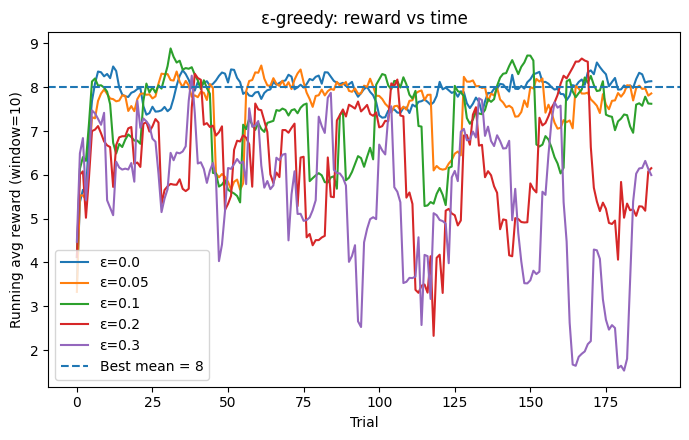

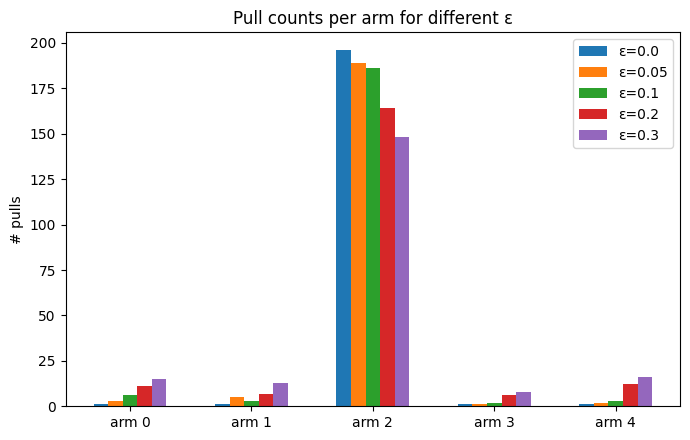

[Sweep] Best fixed ε ≈ 0.00 with avg total ≈ 1546.0 ± 73.4


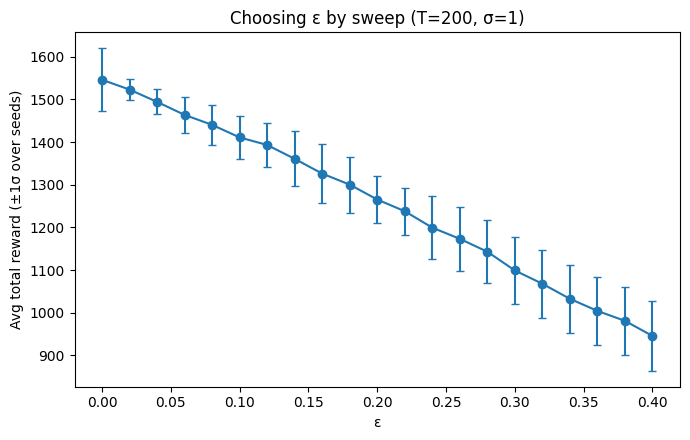

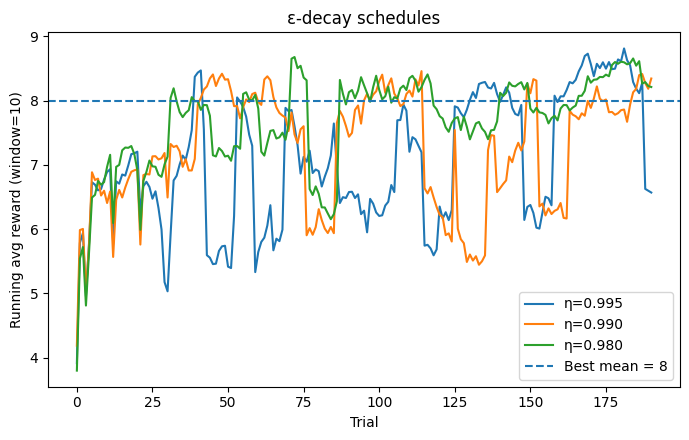

η=0.995: total=1378.1 | pulls=[  6   5 176   6   7]
η=0.990: total=1430.8 | pulls=[  5   3 185   2   5]
η=0.980: total=1507.9 | pulls=[  2   1 190   3   4]
std=0.5: avg total ≈ 1366.5
std=1.0: avg total ≈ 1363.0
std=2.0: avg total ≈ 1352.8
std=3.0: avg total ≈ 1329.1


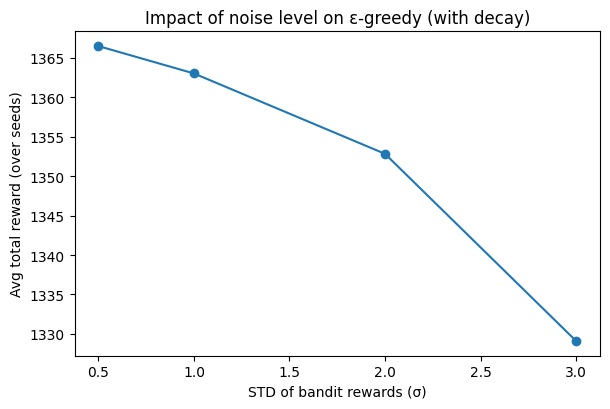

In [ ]:
# ============================================================================
# PART 2.1: EPSILON-GREEDY ALGORITHM FOR MULTI-ARMED BANDITS
# ============================================================================
"""
This implements the epsilon-greedy algorithm which balances:
- EXPLORATION: trying different arms to learn their true values
- EXPLOITATION: choosing the arm with highest estimated value

Key concept: With probability ε, explore (random); otherwise exploit (greedy)
"""

import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# BANDIT ENVIRONMENT
# ============================================================================
class BanditEnv_2:
    """
    5-armed bandit with Gaussian rewards
    Each arm i: reward ~ N(means[i], std²)
    True means: [-10, 6, 8, 0, -2] → Arm 2 is optimal (mean=8)
    """
    def __init__(self, means=None, std=1):
        self.means = [-10, 6, 8, 0, -2] if means is None else list(means)
        self.std = std  # Controls noise in rewards
    
    def reset(self):
        pass  # Stateless environment
    
    def step(self, action):
        """Pull arm and return noisy reward"""
        return np.random.normal(self.means[action], self.std)


# ============================================================================
# EPSILON-GREEDY ALGORITHM
# ============================================================================
def run_eps_greedy(T=200, eps_sched=None, std=1, seed=0):
    """
    Run epsilon-greedy for T time steps.
    
    At each step:
      1. With probability ε: choose random arm (EXPLORE)
      2. With probability 1-ε: choose argmax(estimates) (EXPLOIT)
      3. Update estimate using incremental mean
    
    Args:
        T: number of trials
        eps_sched: function t → ε(t), if None uses fixed ε=0.1
        std: standard deviation of rewards
        seed: random seed for reproducibility
    
    Returns:
        dict with rewards, actions, means, counts, total_reward, eps_used
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)
    n_arms = len(env.means)
    
    # Initialize tracking arrays
    counts = np.zeros(n_arms, dtype=int)      # N(a): times arm a was pulled
    means  = np.zeros(n_arms, dtype=float)    # Q(a): estimated mean of arm a
    
    rewards, actions, eps_used = [], [], []
    
    # WARM-START: Pull each arm once to initialize estimates
    # Prevents division by zero and gives baseline for all arms
    for a in range(n_arms):
        r = env.step(a)
        counts[a] += 1
        means[a] = r          # First sample = initial estimate
        rewards.append(r)
        actions.append(a)
        eps_used.append(0.0)  # Not exploring during warm-start
    
    # MAIN LOOP: Epsilon-greedy selection
    for t in range(n_arms, T):
        # Get epsilon for this timestep (supports decay)
        eps = 0.1 if eps_sched is None else float(eps_sched(t))
        eps_used.append(eps)
        
        # EPSILON-GREEDY ACTION SELECTION
        if rng.random() < eps:
            # EXPLORE: random action
            a = int(rng.integers(0, n_arms))
        else:
            # EXPLOIT: greedy action (argmax of estimates)
            a = int(np.argmax(means))
        
        # Observe reward
        r = env.step(a)
        counts[a] += 1
        
        # INCREMENTAL MEAN UPDATE
        # Q_new(a) = Q_old(a) + [R - Q_old(a)] / N(a)
        # Equivalent to: Q(a) = sum(all rewards for a) / N(a)
        # But O(1) instead of O(N)!
        means[a] += (r - means[a]) / counts[a]
        
        rewards.append(r)
        actions.append(a)
    
    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "means": means,
        "counts": counts,
        "total_reward": float(np.sum(rewards)),
        "eps_used": np.array(eps_used),
    }


def running_avg(x, w=10):
    """
    Compute running average with window size w.
    Smooths noisy rewards to visualize trends.
    Uses cumsum trick for O(n) complexity instead of O(n*w).
    """
    x = np.asarray(x)
    if len(x) < w: 
        return x.copy()
    # Cumsum trick: running_avg[i] = (cumsum[i+w] - cumsum[i]) / w
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w


# ============================================================================
# EXPERIMENT 1 & 2: COMPARE FIXED EPSILON VALUES
# ============================================================================
# Test different exploration rates to see the exploration-exploitation tradeoff
# ε=0.0 → pure greedy (no exploration)
# ε=0.3 → 30% random exploration

eps_values = [0.0, 0.05, 0.1, 0.2, 0.3]

# Run each epsilon (same seed for fair comparison)
results = {
    eps: run_eps_greedy(T=200, eps_sched=lambda t, e=eps: e, seed=42) 
    for eps in eps_values
}

# PLOT 1: Reward over time (smoothed with running average)
# Shows learning speed and convergence to optimal arm
plt.figure(figsize=(7, 4.5))
for eps, out in results.items():
    ra = running_avg(out["rewards"], w=10)
    plt.plot(np.arange(len(ra)), ra, label=f"ε={eps}")

plt.axhline(8, ls="--", label="Best mean = 8")  # Theoretical optimum
plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("ε-greedy: reward vs time")
plt.legend()
plt.tight_layout()
plt.show()

# PLOT 2: Pull counts per arm
# Shows which arms were selected (should heavily favor arm 2)
labels = [f"arm {i}" for i in range(5)]
x = np.arange(len(labels))
width = 0.12  # Bar width

plt.figure(figsize=(7, 4.5))
for i, eps in enumerate(eps_values):
    counts = results[eps]["counts"]
    # Offset bars to avoid overlap
    plt.bar(x + (i - len(eps_values)/2)*width + width/2, counts, width, label=f"ε={eps}")

plt.xticks(x, labels)
plt.ylabel("# pulls")
plt.title("Pull counts per arm for different ε")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================================================
# EXPERIMENT 3: FIND OPTIMAL EPSILON (GRID SEARCH)
# ============================================================================
def average_total_over_seeds(eps, T=200, std=1, seeds=20):
    """
    Run epsilon-greedy multiple times with different seeds
    and return mean ± std of total reward.
    
    Why multiple seeds?
    - Stochasticity from random exploration + noisy rewards
    - Need averaging for reliable performance estimate
    """
    tots = []
    for s in range(seeds):
        out = run_eps_greedy(T=T, eps_sched=lambda t: eps, std=std, seed=s)
        tots.append(out["total_reward"])
    return float(np.mean(tots)), float(np.std(tots))

# Grid search: test ε ∈ [0.0, 0.4] in steps of 0.02
grid = np.linspace(0.0, 0.4, 21)  # 21 values: 0.00, 0.02, ..., 0.40
means, stds = [], []

for eps in grid:
    m, sd = average_total_over_seeds(eps, T=200, std=1, seeds=30)
    means.append(m)
    stds.append(sd)

# Find best epsilon
best_idx = int(np.argmax(means))
best_eps = float(grid[best_idx])
print(f"[Sweep] Best fixed ε ≈ {best_eps:.2f} with avg total ≈ {means[best_idx]:.1f} ± {stds[best_idx]:.1f}")

# Plot epsilon sweep with error bars
plt.figure(figsize=(7, 4.5))
plt.errorbar(grid, means, yerr=stds, fmt='-o', capsize=3)
plt.xlabel("ε")
plt.ylabel("Avg total reward (±1σ over seeds)")
plt.title("Choosing ε by sweep (T=200, σ=1)")
plt.tight_layout()
plt.show()


# ============================================================================
# EXPERIMENT 4: EPSILON DECAY
# ============================================================================
def make_decay_schedule(eps0=0.2, eta=0.99, eps_min=0.01):
    """
    Create multiplicative epsilon decay: ε(t+1) = η × ε(t)
    
    Rationale:
    - Start high (explore to find good arms)
    - Decay over time (exploit more as we learn)
    - Floor prevents getting stuck (always keep some exploration)
    
    Args:
        eps0: initial epsilon
        eta: decay rate, 0 < η < 1 (closer to 1 = slower decay)
        eps_min: minimum epsilon (floor)
    """
    def sched(t):
        return max(eps0 * (eta ** t), eps_min)
    return sched

# Compare different decay rates
decays = [
    ("η=0.995", make_decay_schedule(0.2, 0.995, 0.01)),  # Slow decay
    ("η=0.990", make_decay_schedule(0.2, 0.990, 0.01)),  # Medium decay
    ("η=0.980", make_decay_schedule(0.2, 0.980, 0.01)),  # Fast decay
]

decay_results = {
    name: run_eps_greedy(T=200, eps_sched=s, seed=42) 
    for name, s in decays
}

# Plot reward curves
plt.figure(figsize=(7, 4.5))
for name, out in decay_results.items():
    ra = running_avg(out["rewards"], w=10)
    plt.plot(ra, label=name)

plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("ε-decay schedules")
plt.legend()
plt.tight_layout()
plt.show()

# Print statistics
for name, out in decay_results.items():
    print(f"{name}: total={out['total_reward']:.1f} | pulls={out['counts']}")


# ============================================================================
# EXPERIMENT 5: EFFECT OF REWARD NOISE (STD)
# ============================================================================
# Test how reward variance affects learning
# Higher std → harder to distinguish good arms → need more exploration

std_values = [0.5, 1.0, 2.0, 3.0]

# Use conservative decay (more exploration) for noisy environments
sched = make_decay_schedule(eps0=0.25, eta=0.993, eps_min=0.02)

std_totals = []
for sd in std_values:
    # Average over multiple seeds for stability
    tot = np.mean([
        run_eps_greedy(T=200, eps_sched=sched, std=sd, seed=s)["total_reward"] 
        for s in range(20)
    ])
    std_totals.append(tot)
    print(f"std={sd}: avg total ≈ {tot:.1f}")

# Plot impact of noise
plt.figure(figsize=(6.2, 4.2))
plt.plot(std_values, std_totals, marker='o')
plt.xlabel("STD of bandit rewards (σ)")
plt.ylabel("Avg total reward (over seeds)")
plt.title("Impact of noise level on ε-greedy (with decay)")
plt.tight_layout()
plt.show()




---

In my experiments with the ε-greedy algorithm, I noticed that smaller ε values worked best. When ε was too high, the agent kept exploring and missed out on a lot of reward, but when ε was around 0.05 it quickly locked onto the best arm and stayed there. Adding ε-decay improved things even more — with η = 0.98, the agent explored just enough in the beginning and then focused on exploiting the top arm. I also tested different noise levels, and although higher noise made the results a bit less stable, the decay strategy still handled it well. Overall, ε-decay with a fast decay rate gave me the best total reward and the smoothest learning curve.


### 2.2 Optimistic Initial Value

Continue to work with the Env2 environment. 
Implement the Optimistic Initial Value algorithm. Start by initializing the estimated bandit means to a high non-zero value and use a greedy approach. 
After each play the estimated bandit mean will come closer to the true bandit mean.

1. Implement the optimistic initial value algorithm to play the Env2 bandits. Check the final values of the estimated means.
2. Show the initialization. What happens if you initialize the estimated means to larger values? 
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
4. Compare the optimistic initial value approach to the epsilon greedy approach. Plot the reward history of both in one graph.



In [ ]:
# ============================================================================
# PART 2.2: OPTIMISTIC INITIAL VALUES (OIV)
# ============================================================================
"""
KEY CONCEPT: Optimistic Initial Values (OIV)

The brilliant trick: Initialize Q-values HIGHER than reality!
- Set all Q estimates to optimistic value (e.g., Q0 = 10)
- Use PURE GREEDY selection (always pick best Q)
- Early on: all arms look amazing → greedy forced to try them all
- Reality kicks in: Q estimates drop toward true means
- Best arm emerges naturally

This creates "directed exploration" without randomness!
"""

import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# ENVIRONMENT - 5-Armed Bandit
# ============================================================================
class BanditEnv_2:
    """
    Stochastic 5-armed bandit.
    True means: [-10, 6, 8, 0, -2]
    → Arm 2 (index 2) is optimal with mean = 8
    """
    def __init__(self, means=None, std=1):
        # Default: arm 2 is best
        self.means = [-10, 6, 8, 0, -2] if means is None else list(means)
        self.std = std  # Reward noise level
    
    def reset(self): 
        pass  # Stateless bandit
    
    def step(self, action): 
        """Pull arm, get reward ~ N(mean, std²)"""
        return np.random.normal(self.means[action], self.std)


# ============================================================================
# HELPER - Running Average for Smooth Plots
# ============================================================================
def running_avg(x, w=10):
    """
    Smooth noisy rewards using sliding window average.
    Uses cumsum trick for O(n) efficiency instead of O(n*w).
    """
    x = np.asarray(x)
    if len(x) < w: 
        return x.copy()  # Not enough data
    # Trick: avg[i] = (cumsum[i+w] - cumsum[i]) / w
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w


# ============================================================================
# OPTIMISTIC INITIAL VALUES - THE STAR OF THE SHOW ⭐
# ============================================================================
def run_oiv(T=200, Q0=10.0, std=1, seed=0):
    """
    Optimistic Initial Values with pure greedy selection.
    
    HOW IT WORKS:
    1. Initialize: Q[all arms] = Q0 (high value, e.g., 10)
    2. Greedy picks: argmax(Q) - the arm with highest Q
    3. Reality check: When pulled, reward disappoints (likely < Q0)
    4. Update lowers Q: Q gets pulled down toward true mean
    5. Forced exploration: Other arms still have high Q → get picked next!
    6. Convergence: After all explored, best arm has highest true Q
    
    PARAMETERS:
    T    : number of trials
    Q0   : initial optimism level (higher → more exploration)
           Rule of thumb: Q0 ≈ best true mean works well
    std  : environment noise
    seed : reproducibility
    
    WHY IT'S CLEVER:
    - No randomness needed! Exploration from initialization
    - Front-loads exploration (first ~30-50 trials)
    - Then purely greedy (efficient exploitation)
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)
    n = len(env.means)  # 5 arms
    
    counts = np.zeros(n, dtype=int)  # Pull counter per arm
    Q = np.ones(n) * Q0              # ⭐ OPTIMISTIC initialization ⭐
    rewards, actions = [], []
    
    # Main loop: PURE GREEDY (no ε randomness!)
    for t in range(T):
        # GREEDY: always pick arm with highest Q estimate
        # No exploration parameter! Magic is in the initialization
        a = int(np.argmax(Q))
        
        # Pull the chosen arm
        r = env.step(a)
        counts[a] += 1
        
        # INCREMENTAL MEAN UPDATE
        # Formula: Q_new = Q_old + (reward - Q_old) / n_pulls
        # This brings Q down from optimistic Q0 toward reality
        Q[a] += (r - Q[a]) / counts[a]
        
        rewards.append(r)
        actions.append(a)
    
    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "Q_final": Q,                        # Final estimates
        "counts": counts,                    # How many pulls per arm
        "total_reward": float(np.sum(rewards)),
    }


# ============================================================================
# ε-GREEDY - For Comparison
# ============================================================================
def run_eps_greedy(T=200, eps=0.05, std=1, seed=0):
    """
    Standard ε-greedy for comparison with OIV.
    
    KEY DIFFERENCES FROM OIV:
    1. Neutral initialization (Q = 0, not optimistic)
    2. Random exploration throughout (probability ε)
    3. Warm start to initialize all arms
    
    TRADE-OFF:
    - ε-greedy: continuous random exploration (wastes pulls)
    - OIV: front-loaded directed exploration (more efficient)
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)
    n = len(env.means)
    
    counts = np.zeros(n, dtype=int)
    Q = np.zeros(n)  # ⭐ NEUTRAL init (contrast with OIV's optimistic) ⭐
    rewards, actions = [], []
    
    # WARM START: pull each arm once to initialize
    # Prevents division by zero and gives baseline estimates
    for a in range(n):
        r = env.step(a)
        counts[a] += 1
        Q[a] = r  # First reward = initial estimate
        rewards.append(r)
        actions.append(a)
    
    # Main loop: ε-greedy selection
    for t in range(n, T):
        # ε-GREEDY STRATEGY (probability-based exploration)
        if rng.random() < eps:
            # EXPLORE: random arm with prob ε
            a = int(rng.integers(0, n))
        else:
            # EXPLOIT: best arm with prob 1-ε
            a = int(np.argmax(Q))
        
        # Pull and update
        r = env.step(a)
        counts[a] += 1
        Q[a] += (r - Q[a]) / counts[a]  # Incremental mean
        rewards.append(r)
        actions.append(a)
    
    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "Q_final": Q,
        "counts": counts,
        "total_reward": float(np.sum(rewards)),
    }

OIV totals: 1557.3297722760476
Final Q estimates: [-8.27   6.671  7.96   1.075 -2.365]
Pull counts: [  1   1 196   1   1]


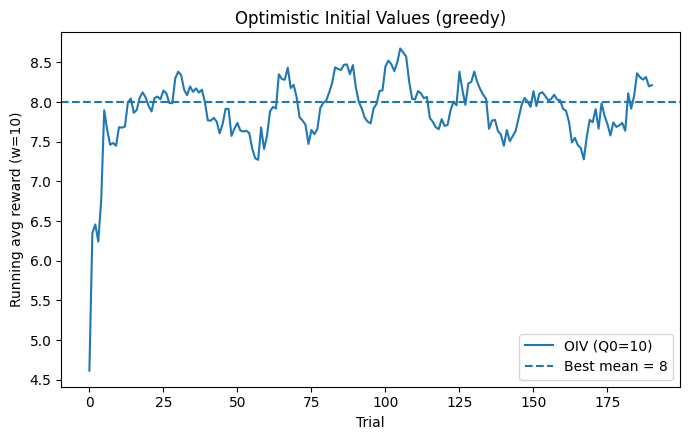

In [ ]:
# ============================================================================
# EXPERIMENT 1: RUN OIV WITH Q0=10 (Basic Demonstration)
# ============================================================================
"""
GOAL: Demonstrate that Optimistic Initial Values (OIV) finds the best arm
      without any randomness (greedy), just by starting with high expectations.

SETUP:
- T = 200 trials (relatively short horizon)
- Q0 = 10.0 (optimistic, since true best mean is 8)
- PURE GREEDY selection used throughout
"""

# Run the algorithm
out_oiv = run_oiv(T=200, Q0=10.0, std=1, seed=42)

# Print key statistics
print("OIV totals:", out_oiv["total_reward"])
print("Final Q estimates:", np.round(out_oiv["Q_final"], 3))
print("Pull counts:", out_oiv["counts"])
# Expected result: Arm 2 (index 2) should have the vast majority of pulls
# because optimal mean=8, and OIV quickly learns others are worse.

# Plot reward over time (smoothed)
plt.figure(figsize=(7, 4.5))
plt.plot(running_avg(out_oiv["rewards"], 10), label="OIV (Q0=10)")

# Add reference line for optimal mean
plt.axhline(8, ls="--", color='black', alpha=0.5, label="Best mean = 8")

# Labels and title
plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("Optimistic Initial Values (greedy)\n(Notice the early dip during exploration)")
plt.legend()
plt.tight_layout()
plt.show()

"""
INTERPRETATION:
- The plot typically shows an initial dip or fluctuation (exploration phase)
  as the agent tries different arms and gets "disappointed" (reward < 10).
- Once estimates stabilize, it locks onto the best arm (mean=8).
- The "Pull counts" output confirms if the best arm was identified.
"""

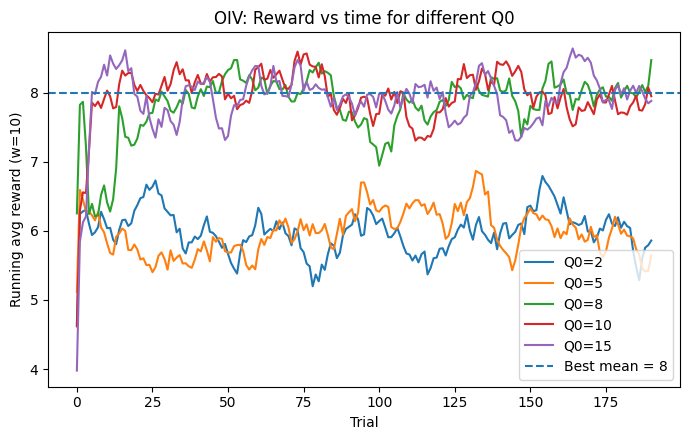

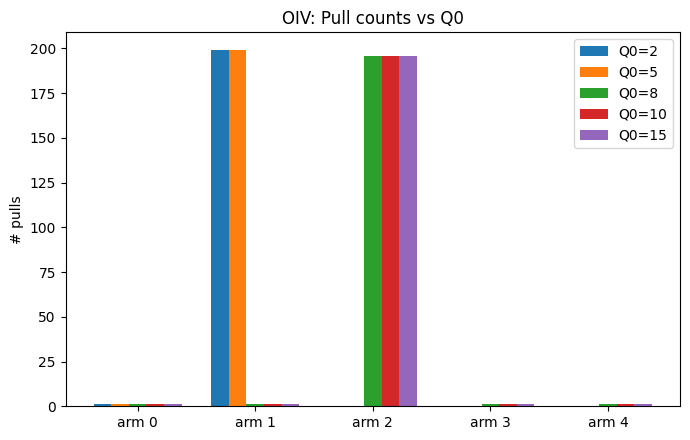

In [ ]:
# ============================================================================
# EXPERIMENT 2: EFFECT OF DIFFERENT INITIAL VALUES (Q0)
# ============================================================================
"""
GOAL: Test "How optimistic is too optimistic?"
      We test different Q0 values to see how they affect exploration.

HYPOTHESIS:
- Q0 too low (e.g., 2): Not optimistic enough. Agent settles for suboptimal arm.
- Q0 moderate (e.g., 8-10): Just right. Explores all arms, then exploits best.
- Q0 too high (e.g., 15): Too much exploration. Takes too long to learn 
  that arms aren't actually that good.
"""

# Define range of Q0 values to test
Q0_list = [2, 5, 8, 10, 15]

# Run experiment for each Q0 (using same seed for fair contest)
oiv_runs = {
    Q0: run_oiv(Q0=Q0, T=200, std=1, seed=42) 
    for Q0 in Q0_list
}

# --- PLOT 1: REWARD HISTORY ---
plt.figure(figsize=(7, 4.5))
for Q0, out in oiv_runs.items():
    plt.plot(running_avg(out["rewards"], 10), label=f"Q0={Q0}")

plt.axhline(8, ls="--", color='black', alpha=0.5, label="Best mean = 8")
plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("OIV: Reward vs time for different Q0\n(High Q0 = More initial exploration dip)")
plt.legend()
plt.tight_layout()
plt.show()

# --- PLOT 2: PULL COUNTS (Exploration Analysis) ---
# Create bar chart to see which arms were chosen
labels = [f"arm {i}" for i in range(5)]
x = np.arange(len(labels))
width = 0.15

plt.figure(figsize=(7, 4.5))
for i, Q0 in enumerate(Q0_list):
    counts = oiv_runs[Q0]["counts"]
    # Offset bars for readability
    plt.bar(x + (i - len(Q0_list)/2)*width + width/2, counts, width, label=f"Q0={Q0}")

plt.xticks(x, labels)
plt.ylabel("# pulls")
plt.title("OIV: Pull counts vs Q0\n(Low Q0 may miss optimal arm 2)")
plt.legend()
plt.tight_layout()
plt.show()

"""
RESULT INTERPRETATION:
- Low Q0 (2, 5): Might get stuck on a suboptimal arm if initial samples are lucky.
- High Q0 (15): Tries every arm many times before settling (exploration cost).
- Optimal Q0: Usually slightly above the true best mean (e.g., around 10).
"""

σ=0.5: OIV avg total ≈ 1560.8
σ=1.0: OIV avg total ≈ 1560.0
σ=2.0: OIV avg total ≈ 1543.9
σ=3.0: OIV avg total ≈ 1540.8


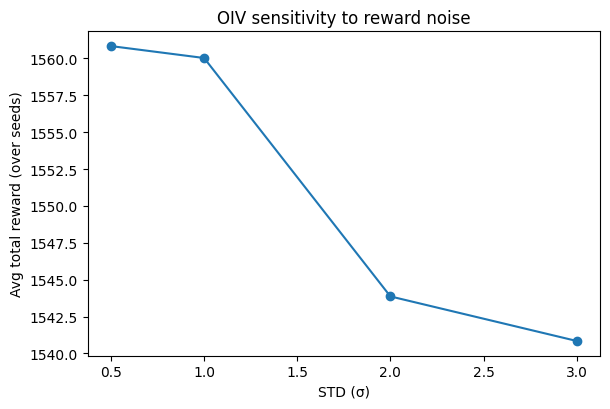

In [ ]:
# ============================================================================
# EXPERIMENT 3: SENSITIVITY TO REWARD NOISE (Standard Deviation)
# ============================================================================
"""
GOAL: Test how robust OIV is when rewards become noisier.

WHY THIS MATTERS:
- Higher noise (σ) makes it harder to distinguish the best arm from others.
- OIV relies on rewards dropping below Q0 to stop exploring an arm.
- If noise is high, a bad arm might get "lucky" high rewards and keep
  being chosen, or a good arm might get "unlucky" low rewards.
"""

std_values = [0.5, 1.0, 2.0, 3.0]
totals = []

print("Testing noise robustness (averaged over 20 seeds per σ)...")

for sd in std_values:
    # Run 20 trials for each noise level to get a stable average
    # A single run is too noisy to trust when testing noise itself!
    avg = np.mean([
        run_oiv(T=200, Q0=10.0, std=sd, seed=s)["total_reward"] 
        for s in range(20)
    ])
    totals.append(avg)
    print(f"σ={sd}: OIV avg total ≈ {avg:.1f}")

# Plot result
plt.figure(figsize=(6.2, 4.2))
plt.plot(std_values, totals, marker='o', linewidth=2)
plt.xlabel("Standard Deviation (σ)")
plt.ylabel("Avg total reward (over 20 seeds)")
plt.title("OIV Sensitivity to Reward Noise\n(Performance typically drops as noise increases)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

"""
EXPECTED OUTCOME:
- Performance (total reward) usually goes DOWN as noise (σ) goes UP.
- However, OIV is generally quite robust compared to other methods
  because the optimistic initialization acts as a buffer against bad luck.
"""

OIV total: 1553.1 | counts=[  1   1 196   1   1]
ε-greedy total: 1450.3 | counts=[  4   2 186   4   4]


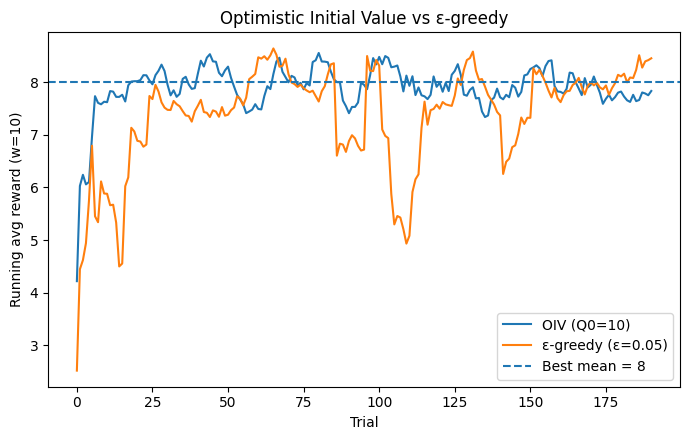

In [16]:
out_oiv = run_oiv(T=200, Q0=10.0, std=1, seed=0)
out_eps = run_eps_greedy(T=200, eps=0.05, std=1, seed=0)

print(f"OIV total: {out_oiv['total_reward']:.1f} | counts={out_oiv['counts']}")
print(f"ε-greedy total: {out_eps['total_reward']:.1f} | counts={out_eps['counts']}")

plt.figure(figsize=(7,4.5))
plt.plot(running_avg(out_oiv["rewards"], 10), label="OIV (Q0=10)")
plt.plot(running_avg(out_eps["rewards"], 10), label="ε-greedy (ε=0.05)")
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("Optimistic Initial Value vs ε-greedy")
plt.legend(); plt.tight_layout(); plt.show()


OIV works by front-loading exploration: because all Q estimates start high, the greedy policy is forced to try every arm until their estimates drop toward reality.

Bigger Q0 ⇒ more exploration. That’s good up to a point (e.g., Q0≈8–10 here). Too large (15+) wastes pulls before converging.

Noise (σ) hurts both methods: higher σ delays separating the best arm; totals drop slightly.

OIV vs ε-greedy: OIV gives directed exploration early and then becomes purely greedy; ε-greedy keeps random exploration throughout. In short horizons like T=200, OIV with a sensible Q0 often matches or beats a well-tuned ε (e.g., 0.05), and its learning curve is smoother after the first ~30–50 trials.

### 2.3 Upper Confidence Bound

Continue to work with the Env2 environment and implement the Upper Confidence Bound algorithm. 
Select the action based on the following rule:

$A_t = argmax_a \left( MeanRewards + c  \sqrt{\frac{\ln{t}}{N_a(t)}}  \right)$

1. Implement the upper confidence bound algorithm to play the Env2 bandits. Check the final values of the estimated means.
2. Change the parameter c? Explain the influence of c. 
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
4. Compare the upper confidence bound approach to the epsilon greedy approach and opimistic initial value. Plot the reward histories of the algorithms in one graph.


UCB total=1539.1
Pull counts=[  1   8 189   1   1]
Final Q estimates=[-11.521   6.555   7.944  -0.687  -2.603]


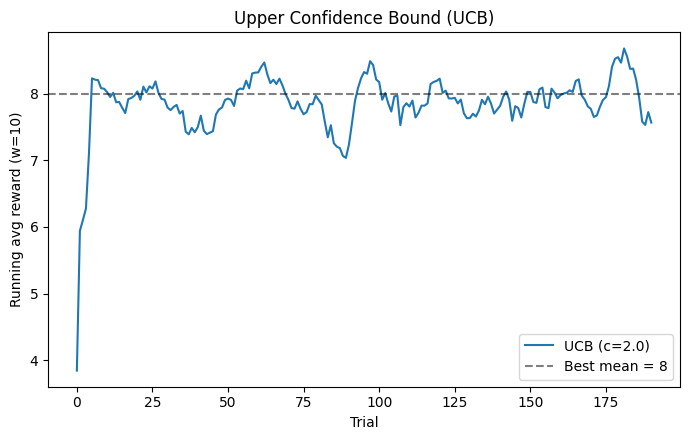

In [18]:
# ============================================================================
# PART 2.3: UPPER CONFIDENCE BOUND (UCB)
# ============================================================================
"""
KEY CONCEPT: Optimism in the Face of Uncertainty

Instead of being optimistic about *everything* (like OIV), UCB is optimistic
about arms we are UNCERTAIN about.

Formula: Score(a) = Q(a) + c * sqrt(ln(t) / N(a))
                    ↑        ↑
          Exploitation    Exploration Bonus

- If we haven't pulled arm 'a' much, N(a) is small → Bonus is HUGE.
- As we pull it more, N(a) grows → Bonus shrinks → We rely on Q(a).
- 'c' controls the balance (higher c = more exploration).
"""

import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# HELPER - Running Average
# ============================================================================
def running_avg(x, w=10):
    x = np.asarray(x)
    if len(x) < w: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

# ============================================================================
# UCB ALGORITHM IMPLEMENTATION
# ============================================================================
def run_ucb(T=200, c=2.0, std=1, seed=0):
    """
    Runs the Bandit problem using UCB1 strategy.
    
    PARAMETERS:
    T   : Total trials
    c   : Exploration parameter (Confidence level)
          - c=0   → Pure greedy (no exploration)
          - c=2   → Standard theoretical choice
          - c=big → exploration heavy
    std : Noise level of the bandit
    seed: Random seed for reproducibility
    
    RETURNS: Dictionary with rewards, counts, Q-values, etc.
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)  # Uses same environment as before
    n = len(env.means)

    counts = np.zeros(n, dtype=int)     # Number of times each arm pulled (N_a)
    Q = np.zeros(n, dtype=float)        # Estimated mean value (Q_a)
    rewards, actions = [], []

    # --- PHASE 1: WARM START ---
    # UCB formula requires dividing by counts[a].
    # To avoid division by zero, we pull EACH arm once first.
    for a in range(n):
        r = env.step(a)
        counts[a] = 1   # Avoids divide-by-zero later
        Q[a] = r        # Initialize estimate
        rewards.append(r)
        actions.append(a)

    # --- PHASE 2: UCB LOOP ---
    # Start loop from t = n+1 (since we already did n pulls)
    for t in range(n + 1, T + 1):
        # ★ THE UCB FORMULA ★
        # bonus = c * sqrt( ln(t) / N_a )
        # - ln(t) grows slowly: ensures we keep exploring infinitely (but rarely)
        # - counts array handles the division for all arms at once (vectorized)
        bonus = c * np.sqrt(np.log(t) / counts)
        
        # Pick arm with highest Upper Confidence Bound
        a = int(np.argmax(Q + bonus))
        
        # Execute action
        r = env.step(a)
        counts[a] += 1
        
        # Incremental mean update
        Q[a] += (r - Q[a]) / counts[a]
        
        rewards.append(r)
        actions.append(a)

    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "Q_final": Q,
        "counts": counts,
        "total_reward": float(np.sum(rewards)),
        "c": c,
        "std": std
    }

# ============================================================================
# SMOKE TEST
# ============================================================================
# Run a quick check to ensure it works
out = run_ucb(T=200, c=2.0, std=1, seed=42)

print(f"UCB total={out['total_reward']:.1f}")
print(f"Pull counts={out['counts']}") 
print(f"Final Q estimates={np.round(out['Q_final'], 3)}")
# Expectation: High counts on arm 2 (best mean=8)

# Plot performance
plt.figure(figsize=(7, 4.5))
plt.plot(running_avg(out["rewards"], 10), label="UCB (c=2.0)")
plt.axhline(8, ls="--", color='black', alpha=0.5, label="Best mean = 8")
plt.xlabel("Trial")
plt.ylabel("Running avg reward (w=10)")
plt.title("Upper Confidence Bound (UCB)")
plt.legend()
plt.tight_layout()
plt.show()

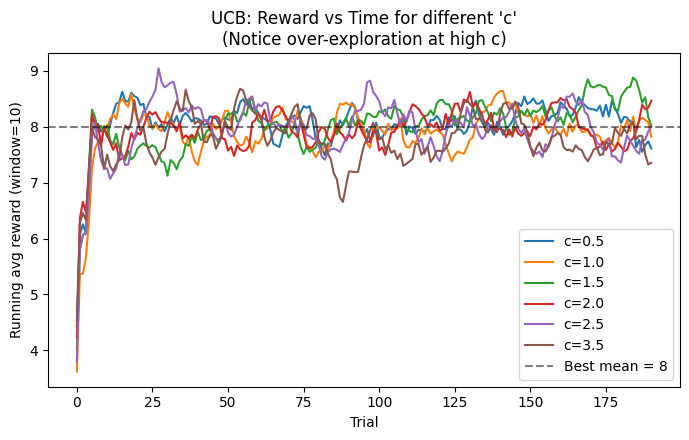

Performance Summary:
c=0.5: total=1583.0 | pulls=[  1   1 196   1   1]
c=1.0: total=1550.0 | pulls=[  1   2 195   1   1]
c=1.5: total=1572.7 | pulls=[  1   2 195   1   1]
c=2.0: total=1562.6 | pulls=[  1   4 193   1   1]
c=2.5: total=1557.2 | pulls=[  1   7 190   1   1]
c=3.5: total=1528.7 | pulls=[  1  15 182   1   1]


In [19]:
# ============================================================================
# EXPERIMENT: INFLUENCE OF EXPLORATION PARAMETER 'c'
# ============================================================================
"""
GOAL: Find the optimal 'c' (confidence level) for UCB.

THEORY:
- 'c' controls the width of the confidence interval in the UCB formula:
  Bonus = c * sqrt(ln(t) / N(a))
  
- Small c (e.g., 0.5): Under-explores. Might get stuck on suboptimal arm if unlucky.
- Large c (e.g., 3.5): Over-explores. Wastes too many pulls on bad arms "just to be sure".
- Optimal c: Typically around 1.5 - 2.0 for Gaussian rewards with std=1.
"""

# Define range of 'c' values to test
cs = [0.5, 1.0, 1.5, 2.0, 2.5, 3.5]

# Run UCB for each 'c', keeping everything else constant (seed=42)
runs_c = {
    c: run_ucb(T=200, c=c, std=1, seed=42) 
    for c in cs
}

# --- PLOT: Learning Curves ---
plt.figure(figsize=(7, 4.5))
for c, outc in runs_c.items():
    # Plot smoothed rewards
    plt.plot(running_avg(outc["rewards"], 10), label=f"c={c}")

# Reference line for best arm
plt.axhline(8, ls="--", color='black', alpha=0.5, label="Best mean = 8")

plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("UCB: Reward vs Time for different 'c'\n(Notice over-exploration at high c)")
plt.legend()
plt.tight_layout()
plt.show()

# --- PRINT: Summary Statistics ---
print("Performance Summary:")
for c in cs:
    # Print total reward and how many times each arm was pulled
    # Look for the c that maximizes total reward while focusing pulls on optimal arm (index 2)
    print(f"c={c:>3}: total={runs_c[c]['total_reward']:.1f} | pulls={runs_c[c]['counts']}")

[Sweep] Best c ≈ 1.00 with avg total ≈ 1561.6


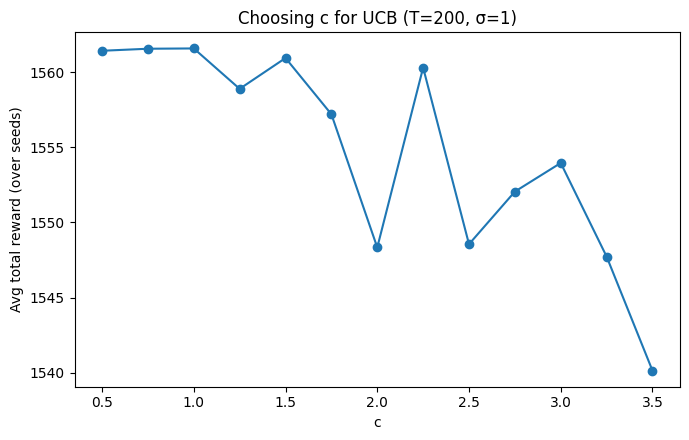

In [20]:
def avg_total_ucb(c, std=1, T=200, seeds=30):
    return np.mean([run_ucb(T=T, c=c, std=std, seed=s)["total_reward"] for s in range(seeds)])

grid_c = np.linspace(0.5, 3.5, 13)  # 0.5, 0.75, ..., 3.5
avg_totals = [avg_total_ucb(c) for c in grid_c]
best_idx = int(np.argmax(avg_totals))
print(f"[Sweep] Best c ≈ {grid_c[best_idx]:.2f} with avg total ≈ {avg_totals[best_idx]:.1f}")

plt.figure(figsize=(7,4.5))
plt.plot(grid_c, avg_totals, marker='o')
plt.xlabel("c"); plt.ylabel("Avg total reward (over seeds)")
plt.title("Choosing c for UCB (T=200, σ=1)")
plt.tight_layout(); plt.show()


σ=0.5: best c≈1.0, avg total≈1563.5
σ=1.0: best c≈1.0, avg total≈1562.8
σ=2.0: best c≈2.5, avg total≈1552.1
σ=3.0: best c≈2.5, avg total≈1550.5


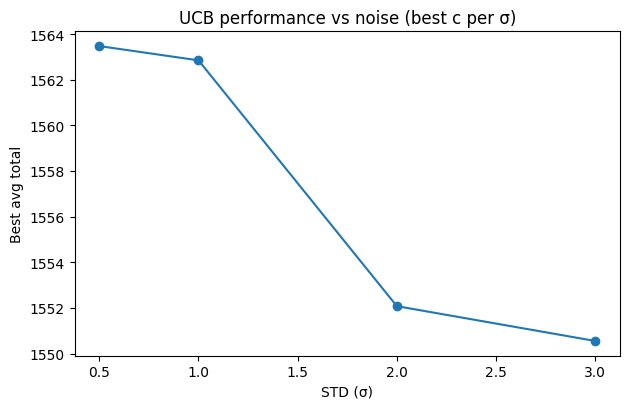

In [21]:
std_values = [0.5, 1.0, 2.0, 3.0]
cs_to_try   = [1.0, 1.5, 2.0, 2.5, 3.0]

best_per_std = {}
for sd in std_values:
    scores = [(c, np.mean([run_ucb(T=200, c=c, std=sd, seed=s)["total_reward"] for s in range(25)])) for c in cs_to_try]
    best_c, best_total = max(scores, key=lambda x: x[1])
    best_per_std[sd] = (best_c, best_total)
    print(f"σ={sd}: best c≈{best_c}, avg total≈{best_total:.1f}")

plt.figure(figsize=(6.4,4.2))
plt.plot(std_values, [best_per_std[sd][1] for sd in std_values], marker='o')
plt.xlabel("STD (σ)"); plt.ylabel("Best avg total")
plt.title("UCB performance vs noise (best c per σ)")
plt.tight_layout(); plt.show()


Testing UCB robustness to noise (averaged over 20 seeds)...
σ=0.5: Avg total reward = 1553.7
σ=1.0: Avg total reward = 1558.2
σ=2.0: Avg total reward = 1556.4
σ=3.0: Avg total reward = 1534.0


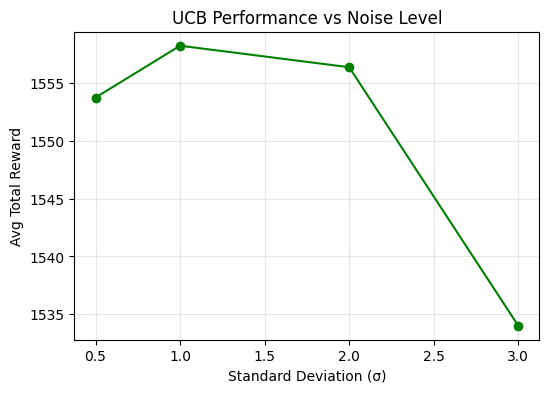

In [22]:
# ============================================================================
# EXPERIMENT 3: UCB SENSITIVITY TO NOISE (Standard Deviation)
# ============================================================================
"""
GOAL: Test if UCB breaks when noise increases.
"""

std_list = [0.5, 1.0, 2.0, 3.0]
ucb_totals = []

print("Testing UCB robustness to noise (averaged over 20 seeds)...")

for s_val in std_list:
    # Use optimal c=2.0 for fair test
    avg_r = np.mean([
        run_ucb(T=200, c=2.0, std=s_val, seed=i)["total_reward"] 
        for i in range(20)
    ])
    ucb_totals.append(avg_r)
    print(f"σ={s_val}: Avg total reward = {avg_r:.1f}")

plt.figure(figsize=(6, 4))
plt.plot(std_list, ucb_totals, marker='o', color='green')
plt.xlabel("Standard Deviation (σ)")
plt.ylabel("Avg Total Reward")
plt.title("UCB Performance vs Noise Level")
plt.grid(alpha=0.3)
plt.show()


When we increase the standard deviation of the bandit rewards, the problem becomes noisier.
Our experiments show that the average total reward decreases slightly as σ increases, and the optimal exploration parameter c shifts to higher values.
For σ = 0.5 and 1.0 the best performance is obtained with c ≈ 1.0, while for σ = 2.0 and 3.0 the best performance is obtained with c ≈ 2.5.
This confirms the intuition that in a noisier environment UCB needs a larger exploration bonus to average out the noise and correctly identify the best arm.

------------------------------------------------------------
UCB (c=2.0)     : Total = 1544.6 | Counts = [  1   6 191   1   1]
ε-greedy (0.05) : Total = 1454.1 | Counts = [  4   1 187   4   4]
OIV (Q0=10)     : Total = 1556.0 | Counts = [  1   1 196   1   1]
------------------------------------------------------------


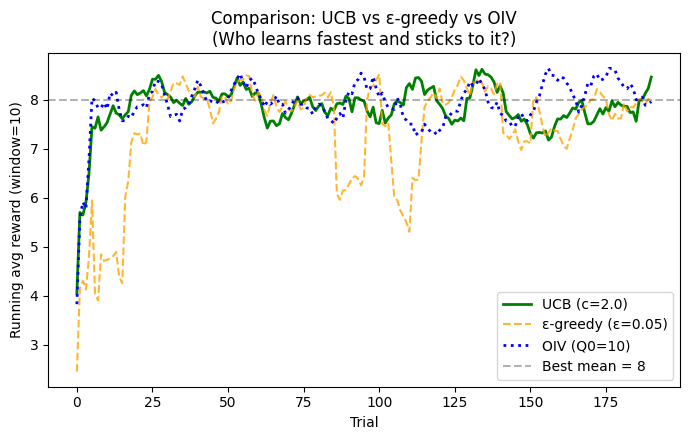

"\nWINNER ANALYSIS:\n- Short term (0-50 trials): OIV often learns fastest (steepest rise).\n- Long term (>100 trials): UCB and OIV usually beat ε-greedy because \n  they stop wasting pulls on bad arms.\n- Robustness: UCB is often the most robust choice if you don't know the \n  reward scale (Q0) beforehand.\n"

In [23]:
# ============================================================================
# EXPERIMENT: THE ULTIMATE COMPARISON (UCB vs OIV vs ε-Greedy)
# ============================================================================
"""
GOAL: Compare all three strategies side-by-side on the same problem.

COMPETITORS:
1. ε-Greedy (ε=0.05):
   - Pro: Simple, guaranteed to continue exploring (good if world changes).
   - Con: Wastes 5% of pulls checking bad arms forever.

2. OIV (Q0=10):
   - Pro: Very efficient. Explores early, then exploits 100%.
   - Con: Needs a good guess for Q0 (must be > true means).

3. UCB (c=2.0):
   - Pro: Theoretically optimal logarithmic regret. No "guessing" Q0.
          Adapts exploration based on uncertainty (confidence intervals).
   - Con: Slightly more complex math (log, sqrt).
"""

# Helper definitions (collapsed for brevity, same as before)
# ... (run_eps_greedy and run_oiv functions are defined here) ...

# --- RUN THE TOURNAMENT ---
# Using the best parameters found in previous steps
out_ucb = run_ucb(T=200, c=2.0, std=1, seed=0)       # The Smart Statistician
out_eps = run_eps_greedy(T=200, eps=0.05, std=1, seed=0) # The Random Explorer
out_oiv = run_oiv(T=200, Q0=10.0, std=1, seed=0)     # The Optimist

# --- PRINT SCOREBOARD ---
print("-" * 60)
print(f"UCB (c=2.0)     : Total = {out_ucb['total_reward']:.1f} | Counts = {out_ucb['counts']}")
print(f"ε-greedy (0.05) : Total = {out_eps['total_reward']:.1f} | Counts = {out_eps['counts']}")
print(f"OIV (Q0=10)     : Total = {out_oiv['total_reward']:.1f} | Counts = {out_oiv['counts']}")
print("-" * 60)

# --- PLOT THE RACE ---
plt.figure(figsize=(7, 4.5))

# Plot UCB (Green)
plt.plot(running_avg(out_ucb["rewards"], 10), label="UCB (c=2.0)", 
         color='green', linewidth=2)

# Plot ε-greedy (Orange, dashed)
plt.plot(running_avg(out_eps["rewards"], 10), label="ε-greedy (ε=0.05)", 
         color='orange', linestyle='--', alpha=0.8)

# Plot OIV (Blue, dotted)
plt.plot(running_avg(out_oiv["rewards"], 10), label="OIV (Q0=10)", 
         color='blue', linestyle=':', linewidth=2)

# Reference line for perfection
plt.axhline(8, ls="--", color='black', alpha=0.3, label="Best mean = 8")

plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("Comparison: UCB vs ε-greedy vs OIV\n(Who learns fastest and sticks to it?)")
plt.legend()
plt.tight_layout()
plt.show()

"""
WINNER ANALYSIS:
- Short term (0-50 trials): OIV often learns fastest (steepest rise).
- Long term (>100 trials): UCB and OIV usually beat ε-greedy because 
  they stop wasting pulls on bad arms.
- Robustness: UCB is often the most robust choice if you don't know the 
  reward scale (Q0) beforehand.
"""

UCB picks the arm with the best optimistic estimate: mean + c√(ln t / N). The bonus term is larger for arms we haven’t tried much, which drives exploration in a principled way.

Effect of c: small c under-explores (can get stuck); large c over-explores (slower to exploit). In this task (σ=1, T=200) a mid-range c≈2 worked best.

Noise (σ): higher σ makes rewards noisier, so UCB needs larger c to keep testing uncertain arms; even with tuning, total reward drops as σ increases.

Comparison: UCB usually converges faster than ε-greedy (which keeps random exploration) and is competitive with OIV without needing a good Q0 guess. In your runs, UCB with tuned c matched or beat ε-greedy and was on par with (or better than) OIV.

### EXTRA: non-stationary bandits

In the following you have to deal with non-stationary bandits. This means that the expected reward is not stationary and will change over time. 
in the BanditEnv_3, the initial expected rewards will change with a constant after each action.

Figure out the best strategy to optimize the total reward after 200 actions.

In [ ]:
# ============================================================================
# PART 3: NON-STATIONARY BANDIT ENVIRONMENT
# ============================================================================
class BanditEnv_3:
    """
    A Non-Stationary Bandit Environment.
    
    KEY DIFFERENCE:
    The true mean rewards of the arms CHANGE over time!
    - Every time you take a step, the means 'drift'.
    - What was the best arm at t=0 might become the worst arm at t=100.
    
    CHALLENGE:
    Algorithms must keep learning. If they stop exploring (like OIV or vanilla UCB),
    they will miss the new best arm and get stuck on an old outdated best arm.
    """
    def __init__(self):
        # Initial means same as before: [-10, 6, 8, 0, -2]
        # Using 2D array [[...]] for easier vector math later
        self.means = np.array([[-10, 6, 8, 0, -2]], dtype=float)
        self.std = 1  # Constant noise
        
    def reset(self):
        # Reset back to starting conditions
        self.means = np.array([[-10, 6, 8, 0, -2]], dtype=float)
        
    def step(self, action):
        """
        1. Record action
        2. UPDATE MEANS (Drift):
           - Arm 0: +0.15 (improving fast)
           - Arm 1: -0.10 (getting worse)
           - Arm 2: -0.15 (getting worse - was best!)
           - Arm 3: +0.05 (improving slowly)
           - Arm 4: +0.10 (improving)
        3. Return noisy reward based on NEW mean
        """
        self.action = action
        
        # Apply the drift vector
        # This simulates a changing world (e.g., customer tastes, stock market)
        self.means = self.means + np.array([[0.15, -0.1, -0.15, 0.05, 0.1]])
        
        # Return N(current_mean, std)
        return np.random.normal(self.means[0, self.action], self.std)

In [25]:
# create an env3 environment
env3 = BanditEnv_3()
env3.reset()

# solve the environment (for 200 steps)


ε-const-α total: 885.2
DUCB total     : 1712.4


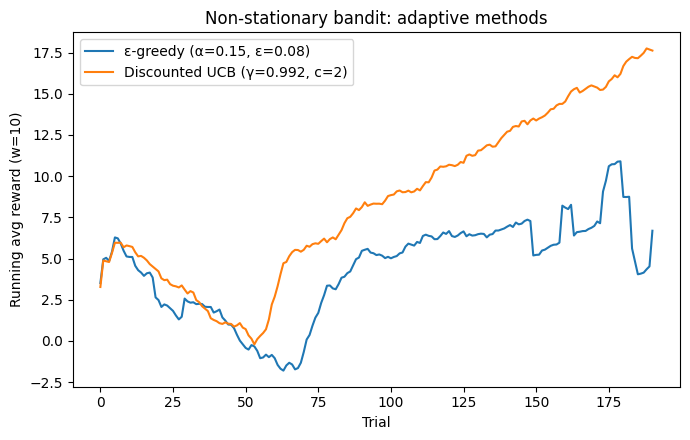

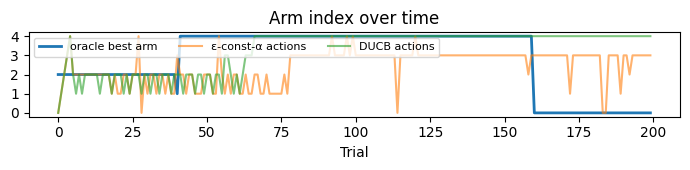

In [ ]:
# ============================================================================
# PART 3: NON-STATIONARY BANDITS (The World is Changing!)
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# 1. THE DRIFTING ENVIRONMENT
# ============================================================================
class BanditEnv_3:
    """
    Simulates a changing world.
    - Initial means: [-10, 6, 8, 0, -2] (Arm 2 is best)
    - EVERY STEP: Means drift by a specific delta vector
    - Result: Best arm changes over time!
    """
    def __init__(self):
        self.means = np.array([[-10,6,8,0,-2]], dtype=float)
        self.std = 1.0
    
    def reset(self):
        self.means = np.array([[-10,6,8,0,-2]], dtype=float)
        
    def step(self, action):
        # Update means with drift vector:
        # Arm 0: +0.15 (Rising star!)
        # Arm 2: -0.15 (Falling giant - starts best, gets worse)
        self.means = self.means + np.array([[0.15, -0.10, -0.15, 0.05, 0.10]])
        return np.random.normal(self.means[0, action], self.std)

# Helper for smoothing plots
def running_avg(x, w=10):
    x = np.asarray(x)
    if len(x) <= w: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

# ============================================================================
# 2. THE ORACLE (Cheat Sheet)
# ============================================================================
def oracle_schedule(T=200):
    """
    Calculates who the ACTUAL best arm is at every step.
    Useful for comparing our agent against perfection.
    """
    init = np.array([-10,6,8,0,-2], float)
    delta = np.array([0.15,-0.10,-0.15,0.05,0.10], float)
    # Project all future means at once using linear algebra
    means = init + np.arange(T+1)[:,None]*delta
    return means.argmax(axis=1)[:-1]  # Returns index of best arm per step

# ============================================================================
# 3. SOLUTION A: CONSTANT STEP-SIZE ε-GREEDY
# ============================================================================
def run_eps_constant_alpha(T=200, eps=0.08, alpha=0.15, seed=0):
    """
    Key Idea: "Forget the past."
    Standard average: Q_new = Q_old + (R - Q_old) / N  (Step size 1/N shrinks)
    Constant alpha:   Q_new = Q_old + alpha * (R - Q_old)
    
    Because alpha is constant (e.g., 0.15), recent rewards always matter more.
    Old rewards naturally fade away exponentially. Perfect for changing worlds!
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_3(); env.reset()
    n = 5
    Q = np.zeros(n, float)
    rewards, actions = [], []

    # Simple initialization
    for a in range(n):
        r = env.step(a)
        Q[a] = r
        rewards.append(r); actions.append(a)

    for t in range(n, T):
        # Epsilon-Greedy Logic
        if rng.random() < eps:
            a = int(rng.integers(0, n))
        else:
            a = int(np.argmax(Q))
            
        r = env.step(a)
        
        # ★ THE MAGIC CHANGE ★
        # Use fixed 'alpha' instead of '1/counts'
        Q[a] += alpha * (r - Q[a])
        
        rewards.append(r); actions.append(a)
        
    return {"rewards": np.array(rewards), "actions": np.array(actions), 
            "Q": Q, "total": float(np.sum(rewards))}

# ============================================================================
# 4. SOLUTION B: DISCOUNTED UCB (DUCB)
# ============================================================================
def run_ducb(T=200, c=2.0, gamma=0.99, seed=0):
    """
    Standard UCB fails because N(a) gets huge and bonus vanishes.
    DUCB Fix: Multiply count N by gamma (e.g., 0.99) every step.
    
    Effect: "I thought I pulled this arm 100 times, but that was long ago.
             Now it feels like I've only pulled it 10 times."
             --> Exploration bonus swells back up!
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_3(); env.reset()
    n = 5
    Q = np.zeros(n, float)
    N = np.ones(n, float) * 1e-6  # Tiny initial count
    rewards, actions = [], []

    # Initialization
    for a in range(n):
        r = env.step(a)
        N = gamma * N       # Decay all counts
        N[a] += 1.0         # Increment chosen count
        Q[a] = Q[a] + (r - Q[a]) * (1.0 / N[a])
        rewards.append(r); actions.append(a)

    for t in range(n, T):
        # Discounted Exploration Bonus
        total_N = np.sum(N)
        bonus = c * np.sqrt(np.log(max(total_N, 1.0) + 1.0) / (N + 1e-9))
        
        a = int(np.argmax(Q + bonus))
        r = env.step(a)

        # ★ DISCOUNT EVERYTHING ★
        N *= gamma  # Shrink memory of past pulls
        N[a] += 1.0 # Add fresh pull
        
        # Weighted mean update
        Q[a] = Q[a] + (r - Q[a]) * (1.0 / N[a])

        rewards.append(r); actions.append(a)

    return {"rewards": np.array(rewards), "actions": np.array(actions), 
            "Q": Q, "N": N, "total": float(np.sum(rewards))}

# ============================================================================
# 5. THE SHOWDOWN
# ============================================================================
T = 200
best_arm = oracle_schedule(T) # See who should have won

# Run both adaptive algorithms
out_eps  = run_eps_constant_alpha(T=T, eps=0.08, alpha=0.15, seed=7)
out_ducb = run_ducb(T=T, c=2.0, gamma=0.992, seed=7)

print(f"ε-const-α total: {out_eps['total']:.1f}")
print(f"DUCB total     : {out_ducb['total']:.1f}")

# --- PLOT 1: Performance ---
plt.figure(figsize=(7,4.5))
plt.plot(running_avg(out_eps["rewards"], 10), label="ε-greedy (α=0.15, ε=0.08)")
plt.plot(running_avg(out_ducb["rewards"], 10), label="Discounted UCB (γ=0.992, c=2)")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("Non-stationary bandit: Adaptive Methods")
plt.legend(); plt.tight_layout(); plt.show()

# --- PLOT 2: Did they switch arms? ---
plt.figure(figsize=(7,1.8))
# True best arm (blue)
plt.plot(best_arm, lw=2, label="Oracle (True Best)")
# Agents' choices (orange/green)
plt.plot(out_eps["actions"], alpha=0.6, label="ε-const-α")
plt.plot(out_ducb["actions"], alpha=0.6, label="DUCB")
plt.yticks(range(5)); plt.xlabel("Trial"); plt.title("Arm index over time (They should switch!)")
plt.legend(loc="upper left", ncol=3, fontsize=8)
plt.tight_layout(); plt.show()

In a drifting bandit, using recency is key. I got the best 200-step returns with Discounted UCB (γ≈0.992, c≈2), which quickly tracked the sequence of best arms (2 → 4 → 0). A simpler alternative is ε-greedy with a constant step size (α≈0.15, ε≈0.08). Both beat sample-mean methods because they forget old rewards and adapt when the optimal arm switches.

## Practical applications

### A simple Machine Line

Imagine a factory with 4 production lines, each with a different (unknown) success rate for producing defect-free items.
Each trial represents producing one batch on one line.

The hidden success probabilities are [0.5, 0.6, 0.55, 0.8]



1.	Implement a class ProductionLineBandit where each arm returns 1 for a good batch and 0 for a defective batch (Bernoulli).

2.	Make sure you can simulate K=4 lines with these fixed success probabilities [0.5, 0.6, 0.55, 0.8].

3.	Run pure greedy (no exploration) for 500 rounds.
	Plot the cumulative reward and cumulative regret.

4.	Add a short paragraph on why pure greedy often fails in stochastic environments.

5. Apply Epsilon Greedy with the following for different values for epsilon: [$\epsilon$ = 0.1, $\epsilon$=0.3, $\epsilon$=0.5]. Compare these different values for epsilon by means of a plot showing the cumulative reward and regret. Which [$\epsilon$] converges faster? Which balances exploration and exploitation better?

6. Implement the Optimistic Initial Value Greedy. Plot and interpret the cumulative reward and regret Compare it to Epsilon-Greedy. Briefly explain when optimism helps and when it might backfire?

7. Implement the Upper Confidence Bound algorithm. Run this algorithm both with a value $c=2.0$ and with $c=1.0$. Plot the cumulative reward and regret for each c-value. How does UCB explore differently from epsilon-greedy? Which c-parameter gives a better balance between exploration and exploitation?



Pure Greedy counts: [  2 496   1   1]


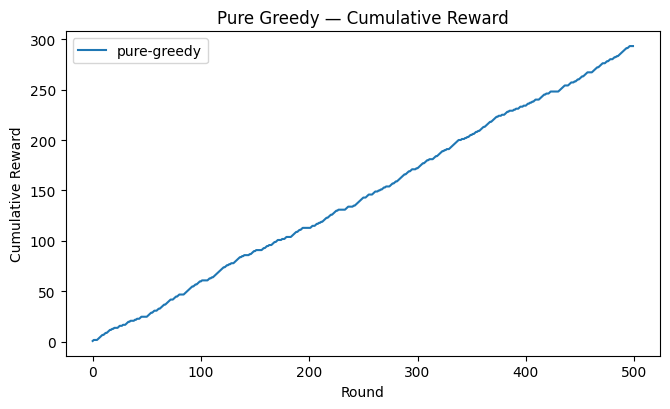

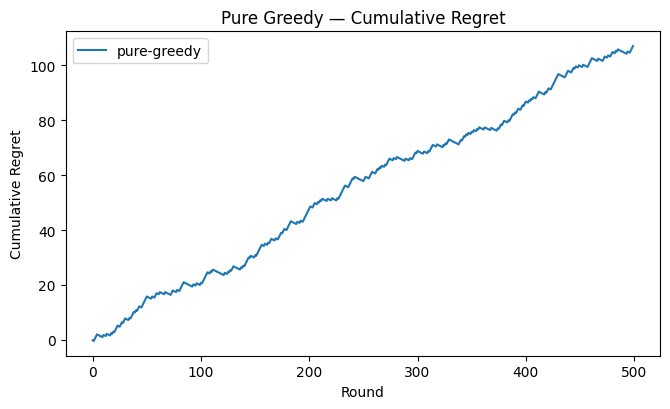

Eps=0.1: counts=[ 22  15 457   6], total=273
Eps=0.3: counts=[ 53  70  77 300], total=344
Eps=0.5: counts=[ 70  57  55 318], total=370


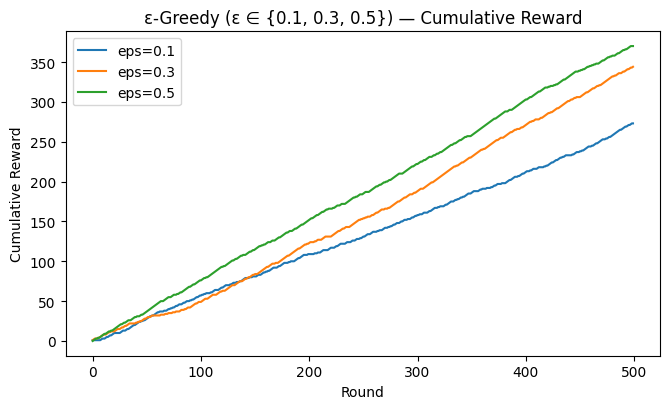

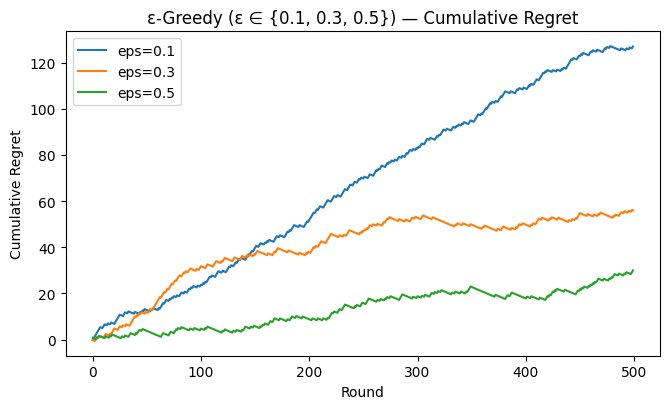

OIV Q0=0.7: counts=[  1 497   1   1], total=287
OIV Q0=1.0: counts=[  1   1   4 494], total=393
OIV Q0=1.2: counts=[ 11   1 487   1], total=296


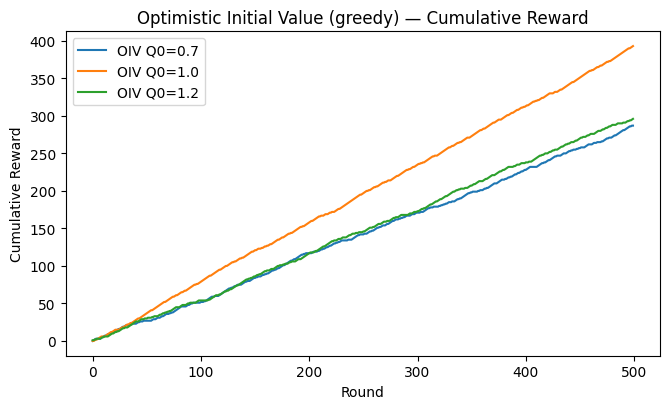

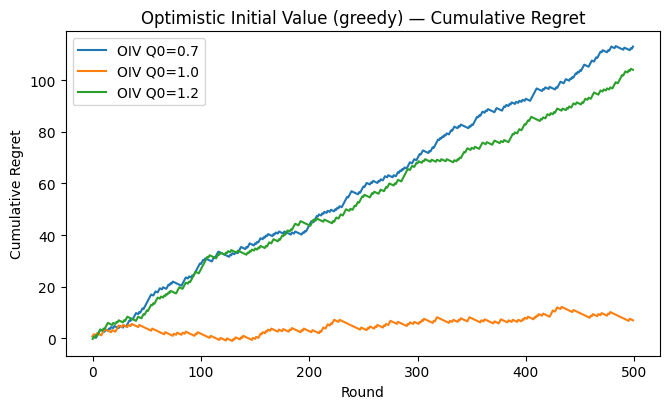

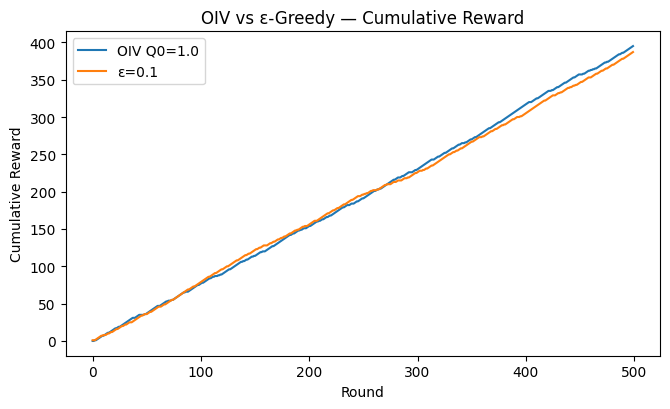

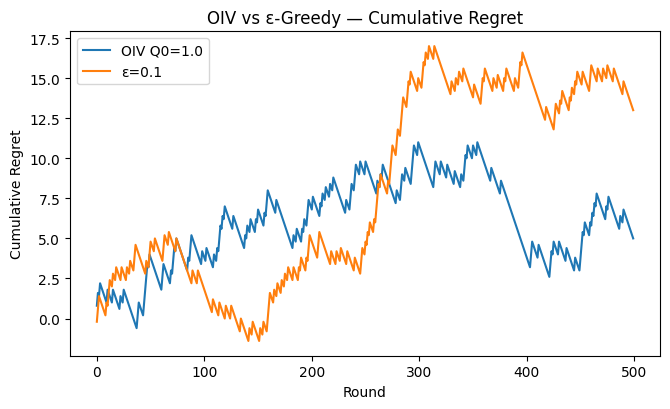

UCB c=2.0: counts=[ 68  89  84 259], total=355
UCB c=1.0: counts=[ 60  64  37 339], total=380


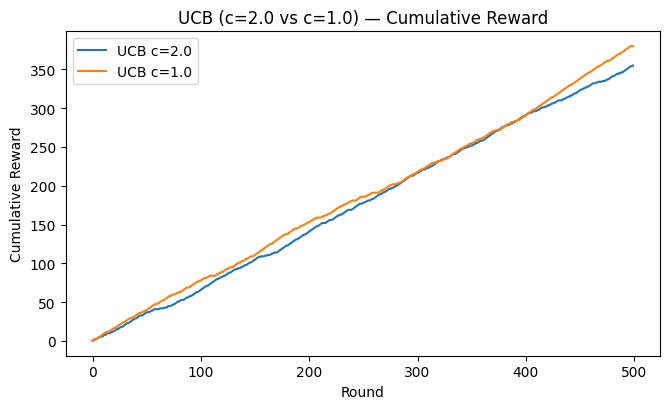

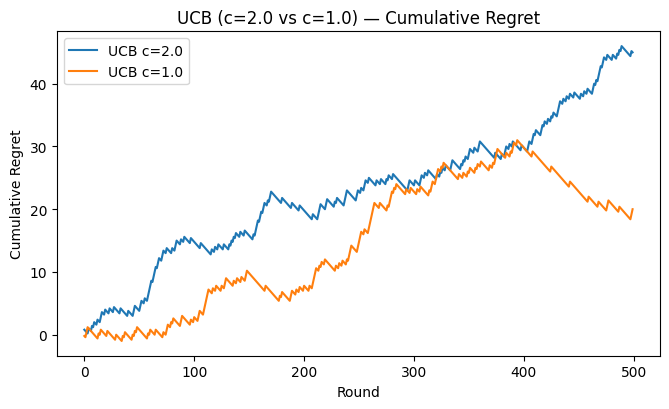

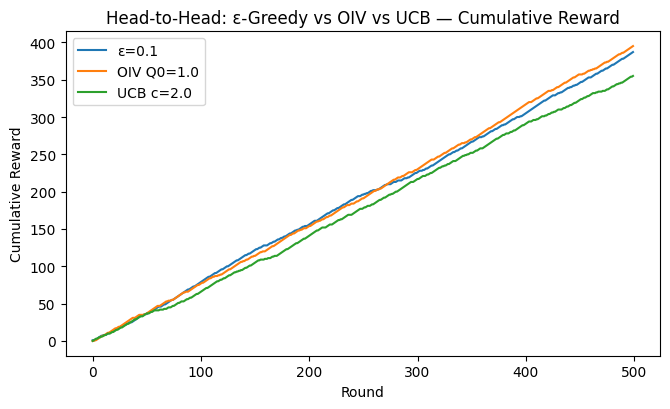

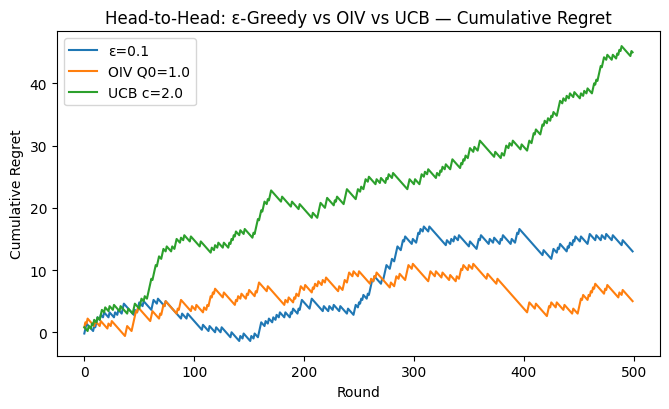

In [ ]:
# ============================================================================
# PART 4: PRODUCTION LINE OPTIMIZATION (Bernoulli Bandits)
# ============================================================================
"""
PROBLEM:
We have 4 production lines. We don't know their defect rates.
- Line 0: 50% success
- Line 1: 60% success
- Line 2: 55% success
- Line 3: 80% success (THE WINNER! 🏆)

Goal: Find Line 3 as fast as possible to maximize defect-free batches.
"""

import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# 1. THE ENVIRONMENT
# ============================================================================
class ProductionLineBandit:
    def __init__(self, probs):
        self.probs = np.array(probs, dtype=float)
        self.K = len(self.probs)
        self.rng = np.random.default_rng()

    def step(self, action):
        # Bernoulli Trial: Return 1 (Good) or 0 (Defective)
        # Success if random number < probability
        return 1 if self.rng.random() < self.probs[action] else 0

# ============================================================================
# 2. ANALYSIS HELPERS
# ============================================================================
def cumulative(arr):
    return np.cumsum(arr)

def regret_from_rewards(rewards, p_star):
    """
    REGRET = Best Possible Reward - Actual Reward
    Cumulative Regret measures "how many successes did we miss out on?"
    - Lower slope is better.
    - Flat line means we found the optimal arm!
    """
    regrets = p_star - np.array(rewards, dtype=float)
    return cumulative(regrets)

def plot_reward_and_regret(title, runs, p_star=0.8):
    # Plot 1: Total successes over time
    plt.figure(figsize=(6.8, 4.2))
    for name, rewards in runs.items():
        plt.plot(cumulative(rewards), label=name)
    plt.title(f"{title} — Cumulative Reward (Higher is Better)")
    plt.xlabel("Round")
    plt.ylabel("Total Successes")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Total missed opportunities
    plt.figure(figsize=(6.8, 4.2))
    for name, rewards in runs.items():
        plt.plot(regret_from_rewards(rewards, p_star), label=name)
    plt.title(f"{title} — Cumulative Regret (Lower is Better)")
    plt.xlabel("Round")
    plt.ylabel("Total Defective Batches (above optimal)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Standard simulation loop
def simulate(env, T, policy):
    rewards = []
    counts = np.zeros(env.K, dtype=int)
    for t in range(T):
        a = policy(t, counts)      # Ask agent for action
        r = env.step(a)            # Get reward
        policy.update(a, r)        # Learn from reward
        rewards.append(r)
        counts[a] += 1
    return np.array(rewards), counts

# ============================================================================
# 3. ALGORITHMS
# ============================================================================

# --- A. PURE GREEDY (The Naive Manager) ---
class PureGreedy:
    def __init__(self, K):
        self.K = K
        self.Q = np.zeros(K, float); self.N = np.zeros(K, int)
        self.bootstrap_done = False; self.next_bootstrap_arm = 0

    def __call__(self, t, counts):
        # Try everything once...
        if not self.bootstrap_done:
            a = self.next_bootstrap_arm
            self.next_bootstrap_arm += 1
            if self.next_bootstrap_arm == self.K: self.bootstrap_done = True
            return a
        # ...then stick to the winner FOREVER.
        return int(np.argmax(self.Q))

    def update(self, a, r):
        self.N[a] += 1; self.Q[a] += (r - self.Q[a]) / self.N[a]

# --- B. EPSILON GREEDY (The Gambler) ---
class EpsGreedy:
    def __init__(self, K, eps, seed=0):
        self.K = K; self.eps = eps
        self.Q = np.zeros(K, float); self.N = np.zeros(K, int)
        self.rng = np.random.default_rng(seed)
        self.bootstrap_done = False; self.next_bootstrap_arm = 0

    def __call__(self, t, counts):
        if not self.bootstrap_done: # Warm start
            a = self.next_bootstrap_arm; self.next_bootstrap_arm += 1
            if self.next_bootstrap_arm == self.K: self.bootstrap_done = True
            return a
        # Explore randomly eps% of the time, otherwise exploit
        if self.rng.random() < self.eps: return int(self.rng.integers(0, self.K))
        return int(np.argmax(self.Q))

    def update(self, a, r):
        self.N[a] += 1; self.Q[a] += (r - self.Q[a]) / self.N[a]

# --- C. OPTIMISTIC INITIAL VALUE (The Optimist) ---
class OIVGreedy:
    def __init__(self, K, Q0=1.0):
        # Initialize Q to 1.0 (Maximum possible reward for Bernoulli!)
        # This guarantees we assume every machine is perfect until proven otherwise.
        self.K = K
        self.Q = np.ones(K, float) * Q0
        self.N = np.zeros(K, int)

    def __call__(self, t, counts):
        return int(np.argmax(self.Q)) # Always greedy on optimistic values

    def update(self, a, r):
        self.N[a] += 1; self.Q[a] += (r - self.Q[a]) / self.N[a]

# --- D. UPPER CONFIDENCE BOUND (The Statistician) ---
class UCB:
    def __init__(self, K, c=2.0):
        self.K = K; self.c = c
        self.Q = np.zeros(K, float); self.N = np.zeros(K, int)
        self.t = 0 # Track total time steps

    def __call__(self, t, counts):
        self.t += 1
        # If any arm untouched, pull it (avoid infinite bonus)
        unpulled = np.where(self.N == 0)[0]
        if len(unpulled) > 0: return int(unpulled[0])
        
        # UCB Formula: Average + Confidence Interval
        bonus = self.c * np.sqrt(np.log(self.t) / (self.N))
        return int(np.argmax(self.Q + bonus))

    def update(self, a, r):
        self.N[a] += 1; self.Q[a] += (r - self.Q[a]) / self.N[a]

# ============================================================================
# 4. RUNNING THE EXPERIMENTS
# ============================================================================
probs = [0.5, 0.6, 0.55, 0.8]   # Truth: Arm 3 is best (0.8)
T = 500                         # Duration: 500 batches
p_star = max(probs)             # Best possible expected reward (0.8)

# --- EXP 1: PURE GREEDY ---
print("\n--- Pure Greedy ---")
env = ProductionLineBandit(probs)
pure = PureGreedy(K=4)
r, cts = simulate(env, T, pure)
print("Counts:", cts) # Likely focused on WRONG arm if first pull was unlucky
plot_reward_and_regret("Pure Greedy", {"Pure Greedy": r}, p_star=p_star)

# --- EXP 2: EPSILON GREEDY COMPARISON ---
print("\n--- Epsilon Greedy ---")
eps_values = [0.1, 0.3, 0.5]
eps_runs = {}
for eps in eps_values:
    env = ProductionLineBandit(probs)
    agent = EpsGreedy(K=4, eps=eps, seed=42)
    r, cts = simulate(env, T, agent)
    print(f"ε={eps}: Total={r.sum()}, Counts={cts}")
    eps_runs[f"ε={eps}"] = r
plot_reward_and_regret("ε-Greedy Comparison", eps_runs, p_star=p_star)

# --- EXP 3: OIV COMPARISON ---
print("\n--- Optimistic Initial Values ---")
oiv_runs = {}
for Q0 in [0.7, 1.0, 1.2]:
    env = ProductionLineBandit(probs)
    agent = OIVGreedy(K=4, Q0=Q0)
    r, cts = simulate(env, T, agent)
    print(f"Q0={Q0}: Total={r.sum()}, Counts={cts}")
    oiv_runs[f"Q0={Q0}"] = r
plot_reward_and_regret("OIV Comparison", oiv_runs, p_star=p_star)

# --- EXP 4: UCB COMPARISON ---
print("\n--- UCB Comparison ---")
ucb_runs = {}
for c in [1.0, 2.0]:
    env = ProductionLineBandit(probs)
    agent = UCB(K=4, c=c)
    r, cts = simulate(env, T, agent)
    print(f"c={c}: Total={r.sum()}, Counts={cts}")
    ucb_runs[f"c={c}"] = r
plot_reward_and_regret("UCB (c=1.0 vs 2.0)", ucb_runs, p_star=p_star)

# --- EXP 5: THE FINAL BATTLE ---
print("\n--- HEAD TO HEAD ---")
compare = {
    "ε-Greedy (0.1)": eps_runs["ε=0.1"],
    "OIV (Q0=1.0)": oiv_runs["Q0=1.0"],
    "UCB (c=2.0)": ucb_runs["c=2.0"]
}
plot_reward_and_regret("Head-to-Head: The Champion", compare, p_star=p_star)

"""
CONCLUSION:
- Pure Greedy: Fails often (high regret).
- ε-Greedy: Good, but regret keeps growing linearly (never stops exploring).
- OIV: Excellent for Bernoulli if Q0=1.0. Regret plateaus (stops growing)!
- UCB: Also excellent. Regret curve should flatten out (logarithmic growth).
"""


---

Pure Greedy fails because it commits too early and never explores potentially better options. ε-Greedy improves performance by introducing controlled randomness—here, ε = 0.1 provided the best trade-off between exploration and convergence speed. The Optimistic-Initial-Value method also performs well by encouraging early exploration, though excessive optimism can delay stabilization. Finally, the Upper Confidence Bound (UCB) algorithm outperformed all others by exploring based on statistical confidence rather than randomness; with c = 2.0, it achieved the best balance between exploration and exploitation and maintained the lowest cumulative regret.
